In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


(480, 640, 3)


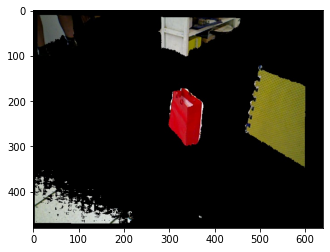

In [105]:
img = cv2.imread('img1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
plt.imshow(img)

In [2]:
def get_bbox_kmeans(image,clusters=2,max_iter=100):
    data = image.reshape((-1,image.shape[-1]))
    # convert to np.float32
    data = np.float32(data)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, max_iter, 1.0)
    K = 5
    ret,label,centers=cv2.kmeans(data,clusters,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    centers = np.uint8(centers)
    resImg = centers[label.flatten()]
    resImg = resImg.reshape((image.shape))
    return centers,resImg

In [73]:
Z = img.reshape((-1,3))
# convert to np.float32
Z = np.float32(Z)
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1.0)
K = 5


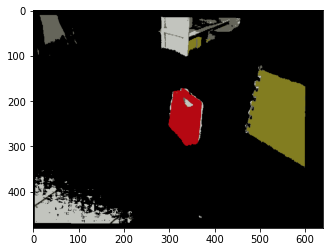

In [99]:
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))
plt.imshow(res2)


In [75]:
for c in center:
    print(c)

[181   8  18]
[194 196 189]
[130 125  32]
[100 100  89]
[0 0 0]


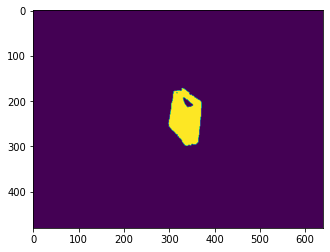

In [91]:
mask1 = cv2.inRange(res2, center[0], center[0])

plt.imshow(mask1)


(298, 171) (372, 299)
74 128


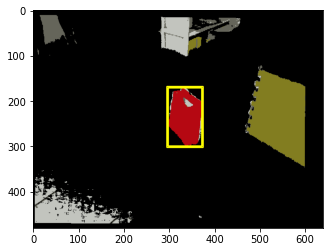

In [103]:
xy_maskpixels = cv2.findNonZero(mask1)
x_min = np.min(xy_maskpixels[:,0,0])
y_min = np.min(xy_maskpixels[:,0,1])

x_max = np.max(xy_maskpixels[:,0,0])
y_max = np.max(xy_maskpixels[:,0,1])


print((x_min,y_min),(x_max,y_max))
print(x_max-x_min,y_max-y_min)
im2 = cv2.rectangle(res2,(x_min,y_min),(x_max,y_max),(255,255,0),2)

plt.imshow(im2)

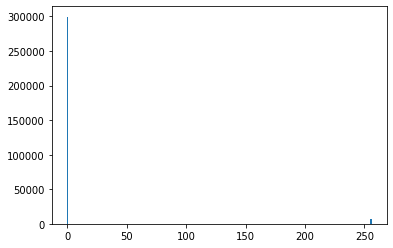

In [94]:
plt.hist(mask1.ravel(), bins=256, range=(0.0, 256.0))
plt.show()

In [176]:
from sensor_msgs.msg import Image 
from cv_bridge import CvBridge, CvBridgeError
import ros_numpy
import rospy
from math import atan2,degrees

In [217]:
import moveit_commander
import moveit_msgs.msg
import trajectory_msgs.msg
import tmc_control_msgs.msg
import actionlib
import control_msgs.msg


In [5]:
class GRIPPER:
    def __init__(self):
        self._grip_cmd_pub = rospy.Publisher(
            '/hsrb/gripper_controller/command',
            trajectory_msgs.msg.JointTrajectory, queue_size=100)
        self._grip_cmd_force = rospy.Publisher(
            '/hsrb/gripper_controller/grasp/goal',
            tmc_control_msgs.msg.GripperApplyEffortActionGoal, queue_size=100)
                    
        self._joint_name = "hand_motor_joint"
        self._position = 0.5
        self._velocity = 0.5
        self._effort = 0.0
        self._duration = 1

    def _manipulate_gripper(self):
        traj = trajectory_msgs.msg.JointTrajectory()
        traj.joint_names = [self._joint_name]
        p = trajectory_msgs.msg.JointTrajectoryPoint()
        p.positions = [self._position]
        p.velocities = [self._velocity]
        p.accelerations = []
        p.effort = [self._effort]
        p.time_from_start = rospy.Duration(self._duration)
        traj.points = [p]
        self._grip_cmd_pub.publish(traj)
        
    def _apply_force(self, force = 0.5):
        app_force = tmc_control_msgs.msg.GripperApplyEffortActionGoal()
        app_force.goal.effort = -force
        self._grip_cmd_force.publish(app_force)
        
    def change_velocity(self, newVel: int):
        self._velocity = newVel
    
    def open(self):
        self._position = 1.23
        self._effort = 0
        self._manipulate_gripper()

    def steady(self):
        self._position = 0.2
        self._effort = -0.3
        self._manipulate_gripper()
        
    def close(self, force = 0.5):
        self._position = 0.0
        self._effort = 0.3
        # self._manipulate_gripper()
        self._apply_force(force)
        rospy.sleep(0.8)


In [6]:
bridge = CvBridge()
rospy.init_node("kmeans_tests", anonymous=True)

In [219]:
class ARM:
    def __init__(self, joint_names = ["arm_lift_joint", "arm_flex_joint", "arm_roll_joint", "wrist_flex_joint", "wrist_roll_joint"],
                 arm_controller_action_client = '/hsrb/arm_trajectory_controller/follow_joint_trajectory'):
        # import tf2_ros
        self._joint_names = joint_names
        self._cli = actionlib.SimpleActionClient(arm_controller_action_client,
            control_msgs.msg.FollowJointTrajectoryAction)
        #self._tf_man = TF_MANAGER()
        #self._grasp_base = OMNIBASE()
        #self._wrist = WRIST_SENSOR()

    def set_joint_values(self, joint_values = [0.0, 0.0, -1.6, -1.6, 0.0]):
        goal = control_msgs.msg.FollowJointTrajectoryGoal()
        traj = trajectory_msgs.msg.JointTrajectory()
        traj.joint_names = self._joint_names
        p = trajectory_msgs.msg.JointTrajectoryPoint()
        p.positions = joint_values
        p.velocities = [0.1, 0.1, 0.1, 0.1, 0.1]
        p.time_from_start = rospy.Duration(0.5)
        traj.points = [p]
        goal.trajectory = traj

        # send message to the action server
        #print('message sent')
        self._cli.send_goal(goal)

        # wait for the action server to complete the order
        return self._cli.wait_for_result()
    
    

In [220]:
arm = ARM()

True

In [251]:
pickup_pose=[0.0,-1.4,0.0,-1.74, 0.0]
gripper = GRIPPER()

In [241]:
gripper.open()


In [252]:
succ= arm.set_joint_values(pickup_pose)
rospy.sleep(1.0)

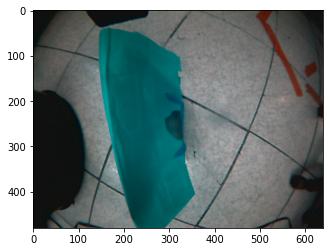

In [276]:

points_msg=rospy.wait_for_message("/hsrb/hand_camera/image_raw",Image, timeout=5)

image2 = ros_numpy.numpify(points_msg)
image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2BGR)
#cv2.imwrite("temp16.jpg",image2)
plt.imshow(image2)

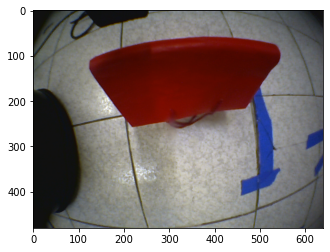

In [260]:
plt.imshow(image2)

In [180]:
print(image2.shape)
#image2[:100,:] = 

(480, 640, 3)


In [245]:
centers,resImg = get_bbox_kmeans(image2,clusters=6,max_iter=400)

(480, 640, 3)


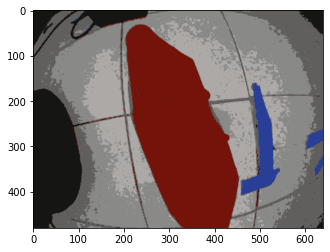

In [246]:
print(resImg.shape)
plt.imshow(resImg)

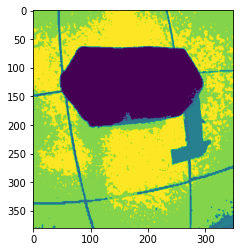

In [110]:
gray = cv2.cvtColor(resImg, cv2.COLOR_BGR2GRAY) 
plt.imshow(gray)

In [143]:
edged = cv2.Canny(mask1, 30, 200) 

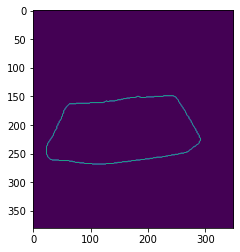

In [144]:
contours, hierarchy = cv2.findContours(edged,  
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
  
plt.imshow( edged) 

In [ ]:
area = cv.contourArea(cnt)

In [107]:
for c in centers:
    print(c)

[130  19  10]
[143 145 139]
[101  83  73]
[170 170 166]
[ 43  65 156]


[115  19  10]


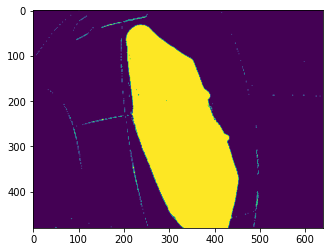

In [247]:
i=2
#mask1 = cv2.inRange(resImg, centers[i], centers[i])
mask1 = cv2.inRange(resImg, resImg[250,350], resImg[250,350])

print(resImg[250,300])
plt.imshow(mask1)


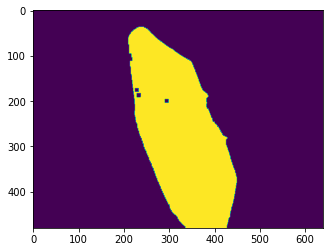

In [248]:
# Creating kernel 
kernel = np.ones((8, 8), np.uint8) 
  
# Using cv2.erode() method  
maskEroded = cv2.erode(mask1, kernel)  
  
# Displaying the image  
plt.imshow(maskEroded)  

In [249]:
xy_maskpixels = cv2.findNonZero(maskEroded)
x_min = np.min(xy_maskpixels[:,0,0])
y_min = np.min(xy_maskpixels[:,0,1])

x_max = np.max(xy_maskpixels[:,0,0])
y_max = np.max(xy_maskpixels[:,0,1])


print((x_min,y_min),(x_max,y_max))
print(x_max-x_min,y_max-y_min)


(210, 37) (449, 479)
239 442


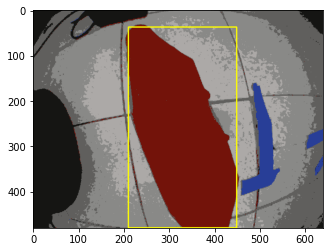

In [250]:
im2 = cv2.rectangle(resImg,(x_min,y_min),(x_max,y_max),(255,255,0),2)

plt.imshow(im2)

In [167]:
def get_orientation(pts, img):
    sz = len(pts)
    data_pts = np.empty((sz, 2), dtype=np.float64)
    for i in range(data_pts.shape[0]):
        data_pts[i,0] = pts[i,0,0]
        data_pts[i,1] = pts[i,0,1]
    # Perform PCA analysis
    mean = np.empty((0))
    mean, eigenvectors, eigenvalues = cv2.PCACompute2(data_pts, mean)
    # Store the center of the object
    cntr = (int(mean[0,0]), int(mean[0,1]))
    cv2.circle(img, cntr, 3, (255, 0, 255), 2)
    p1 = (cntr[0] + 0.02 * eigenvectors[0,0] * eigenvalues[0,0], cntr[1] + 0.02 *  eigenvectors[0,1] * eigenvalues[0,0])
    p2 = (cntr[0] - 0.02 * eigenvectors[1,0] * eigenvalues[1,0], cntr[1] - 0.02 * eigenvectors[1,1] * eigenvalues[1,0])
    #draw_axis(img, cntr, p1, (0, 150, 0), 1)
    #draw_axis(img, cntr, p2, (200, 150, 0), 5)
    angle = atan2(eigenvectors[0,1], eigenvectors[0,0]) # orientation in radians
    return angle

In [237]:
points = cv2.findNonZero(maskEroded)

In [238]:

angle = get_orientation(points, maskEroded)
print(angle,degrees(angle))


1.2230120704252643 70.07342992892426


In [239]:
arm.set_joint_values(joint_values=[0.0,-1.4,0.0,-1.74,angle])

True

0.691973694393815
